In [54]:
import torchvision
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import os 
import matplotlib.pyplot as plt
import time 

In [55]:
current_dir = os.path.dirname(os.path.abspath(''))
data_dir = os.path.join(current_dir, 'final', 'data')
print(data_dir)
if not os.path.exists(data_dir): 
    os.makedirs(data_dir)

/Volumes/Research/neural-network/final/data


In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [57]:
mnist_train = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)

mnist_image = []
mnist_target = []
for image, target in mnist_train: 
    mnist_image.append(np.asarray(image).reshape(-1))
    mnist_target.append(target)

mnist_image = np.asarray(mnist_image)
mnist_target = np.asarray(mnist_target)

# Normalize the image data
mu = np.mean(mnist_image, axis=0).reshape(28, 28)
sigma = np.std(mnist_image, axis=0).reshape(28, 28)

print(f"mu = {mu.shape}, sigma = {sigma.shape}")

mu = (28, 28), sigma = (28, 28)


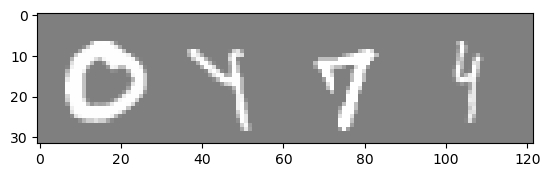

    0     4     7     4
max(mnist_image[0]) = 1.0, min(mnist_image[0]) = 0.0


In [58]:
batch_size=4

# transform = transforms.ToTensor()
tranform = transforms.Normalize(mu, sigma, inplace=False)

# Get MNIST data, normalize, divide by level 
mnist_train = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
testset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, pin_memory=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]:5}' for j in range(batch_size)))
print(f"max(mnist_image[0]) = {torch.max(images[0][0])}, min(mnist_image[0]) = {torch.min(images[0][0])}")

In [59]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        x = self.linear(x)
        return x

net = Net()
net.to(device)

Net(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

size = len(trainloader.dataset)
num_batches = len(trainloader)

running_losses = []
eval_every = 2000
num_epochs = 20 

start_time_s = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    for batch, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        inputs = inputs.view(-1, 784)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        pred = net(inputs)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch % eval_every == (eval_every-1):    # print every 20 mini-batches
            running_loss = running_loss / eval_every
            print(f'[{epoch + 1}, {batch + 1:5d}] loss: {running_loss:.3f}')
            running_losses.append(running_loss)
            running_loss = 0.0

time_s = (time.time() - start_time_s)/num_epochs
print('Finished Training, training time = {} s'.format(time_s))

[1,  2000] loss: 1.609
[1,  4000] loss: 1.010
[1,  6000] loss: 0.815
[1,  8000] loss: 0.702
[1, 10000] loss: 0.644
[1, 12000] loss: 0.587
[1, 14000] loss: 0.569
[2,  2000] loss: 0.520
[2,  4000] loss: 0.512
[2,  6000] loss: 0.486
[2,  8000] loss: 0.487
[2, 10000] loss: 0.466
[2, 12000] loss: 0.462
[2, 14000] loss: 0.448
[3,  2000] loss: 0.448
[3,  4000] loss: 0.432
[3,  6000] loss: 0.426
[3,  8000] loss: 0.421
[3, 10000] loss: 0.405
[3, 12000] loss: 0.423
[3, 14000] loss: 0.395
[4,  2000] loss: 0.400
[4,  4000] loss: 0.403
[4,  6000] loss: 0.398
[4,  8000] loss: 0.393
[4, 10000] loss: 0.390
[4, 12000] loss: 0.385
[4, 14000] loss: 0.377
[5,  2000] loss: 0.385
[5,  4000] loss: 0.384
[5,  6000] loss: 0.364
[5,  8000] loss: 0.370
[5, 10000] loss: 0.368
[5, 12000] loss: 0.387
[5, 14000] loss: 0.363
[6,  2000] loss: 0.359
[6,  4000] loss: 0.379
[6,  6000] loss: 0.363
[6,  8000] loss: 0.347
[6, 10000] loss: 0.362
[6, 12000] loss: 0.360
[6, 14000] loss: 0.352
[7,  2000] loss: 0.352
[7,  4000] 

In [63]:
testloader = DataLoader(testset, batch_size=10000, shuffle=False, pin_memory=True)

num_param = sum(p.numel() for p in net.parameters())
''' Calculate Hessian '''

min_hess = []
max_hess = []

start = time.time()

for _ in range(10): 
    for batch, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        inputs = inputs.view(-1, 784)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        pred = net(inputs)
        loss = criterion(pred, labels)

        # Allocate Hessian size
        H = torch.zeros((num_param, num_param))

        # Calculate Jacobian w.r.t. model parameters
        J = torch.autograd.grad(loss, list(net.parameters()), create_graph=True)
        J = torch.cat([e.flatten() for e in J]) # flatten

        # Fill in Hessian
        for i in range(num_param):
            result = torch.autograd.grad(J[i], list(net.parameters()), retain_graph=True)
            H[i] = torch.cat([r.flatten() for r in result]) # flatten
        
        print(torch.min(H), torch.max(H))

        break 

# print(time.time() - start)

tensor(-0.0189) tensor(0.0352)


In [62]:
tensor(-0.0122) tensor(0.0323)
tensor(-0.0545) tensor(0.0583)
tensor(-0.0265) tensor(0.0730)
tensor(-0.0485) tensor(0.0937)

SyntaxError: invalid syntax (3938758281.py, line 1)

In [ ]:
avg = 0.0323 + 0.0583 + 0.0730 + 0.0937
avg = avg / 4

avg

0.064325

In [ ]:
0.0001

In [ ]:
testloader = DataLoader(testset, batch_size=1, shuffle=False, pin_memory=True)
dataiter = iter(testloader)
images, labels = next(dataiter)

images.size()
image = images[0][0]
image.size()

torch.min(image)
torch.max(image)

tensor(1.)